In [1]:
import numpy as np
import ipywidgets as widgets
from matplotlib import pyplot as plt
from IPython.display import display, HTML

from utils import *

In [2]:
x_points, y_points, line_segments = track_example4()

# Linear Trajectory

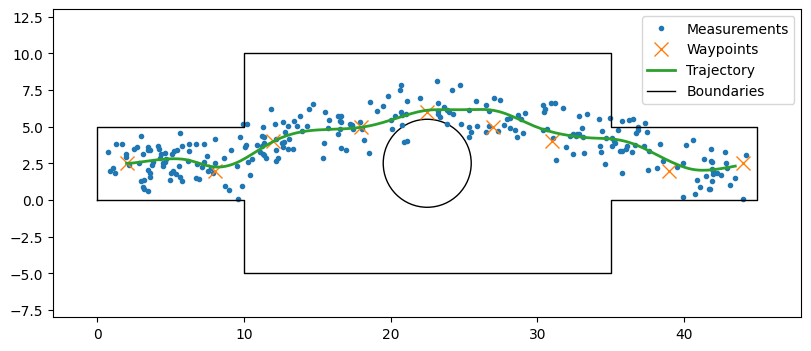

In [3]:
trajectory_linear = MPCTrajectory(x_points, y_points, line_segments, linearity='linear', savepath="output/track_4_linear.pkl")
states, measurements = trajectory_linear.get_data()

circle = plt.Circle((22.5, 2.5), 3, color='k', fill=False)
trajectory_linear.plot(extra=circle)

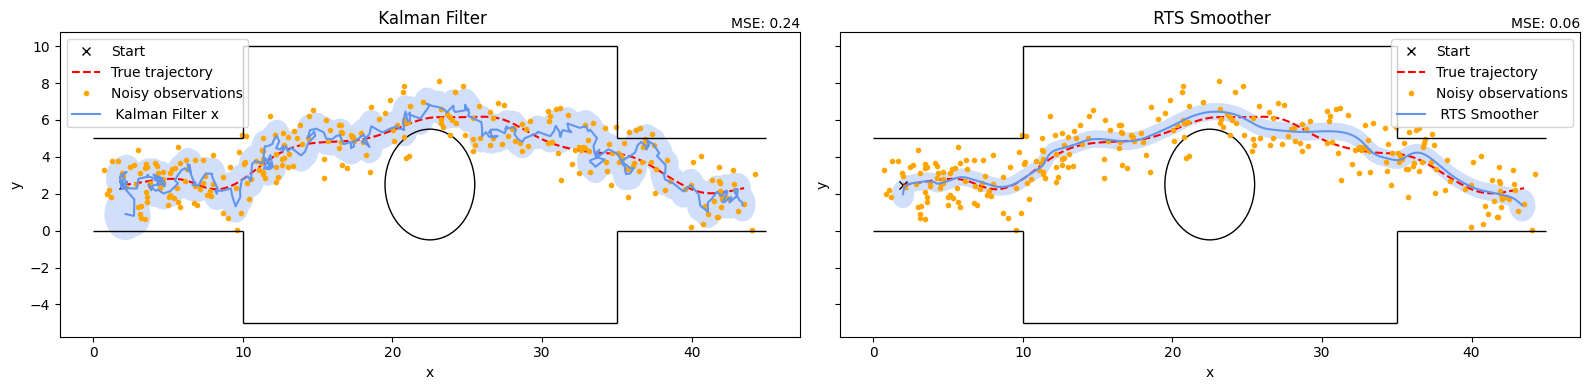

In [4]:
system = StateSpaceModel()

kalman_filter = KF(system.A, system.Q, system.H, system.R)
state_estimates, cov_estimates = kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, extra=circle) # remember that circle is also hard coded in the function

In [5]:
import casadi

def kalman_casadi_opt_linear(states, y, A, Q, H, R):
    
        # x_{t+1} = A x_t + q_t
        # y_{t+1} = H x_{t+1} + r_{t+1}
    
        # J = sum(r^2) + sum(q^2)

        def diff(x, A):
            return x[: ,1:] - A @ x[:, :-1]
    
        opti = casadi.Opti()
    
        # Define the symbolic variables
        n_steps = states.shape[0] 
        n_states =  states.shape[1] # 4
        n_measurements = measurements.shape[1]
    
        # make casadi variables
        y = casadi.MX(y.T)
        A = casadi.MX(A)
        Q = casadi.MX(Q)
        H = casadi.MX(H)
        R = casadi.MX(R)
    
        # Define the decision variables
        x = opti.variable(n_states, n_steps)
        q = opti.variable(n_states, n_steps-1)
        r = opti.variable(n_measurements, n_steps)
    
        #V = casadi.sumsqr(q) + casadi.sumsqr(r) # V = sum(r^2) + sum(q^2)

        v1 = casadi.sumsqr(casadi.mtimes(casadi.inv(Q), q))
        v2 = casadi.sumsqr(casadi.mtimes(casadi.inv(R), r))
        
        V = v1 + v2
        
        # V = x.T R^{-1} x + y.T Q^{-1} y
        #V = casadi.sumsqr(q @ casadi.inv(Q) @ q.T) + casadi.sumsqr(r @ casadi.inv(R) @ r.T)

        opti.subject_to(diff(x, A) == q) # x_{t+1} = A x_t + q_t
        opti.subject_to(y - H @ x == r) # y_{t+1} = H x_{t+1} + r_{t+1}
    
        opti.minimize(V)
    
        opti.solver('ipopt')
    
        sol = opti.solve()
    
        return sol.value(x), sol.value(q), sol.value(r)

casadi_states, casadi_q, casadi_r = kalman_casadi_opt_linear(states, measurements, system.A, system.Q, system.H, system.R)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9088
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3474

Total number of variables............................:     2676
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1604
Total number of inequality c

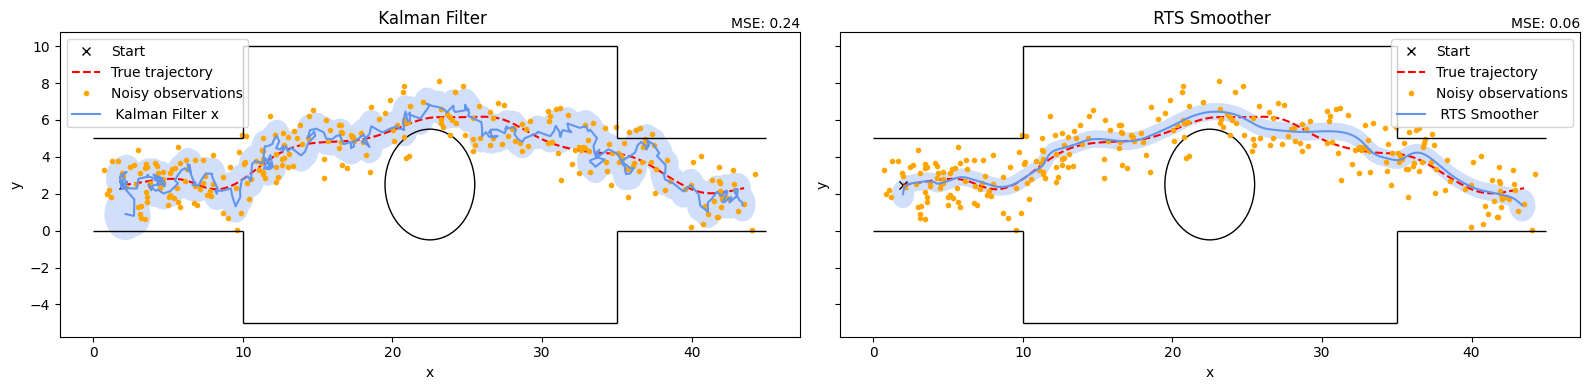

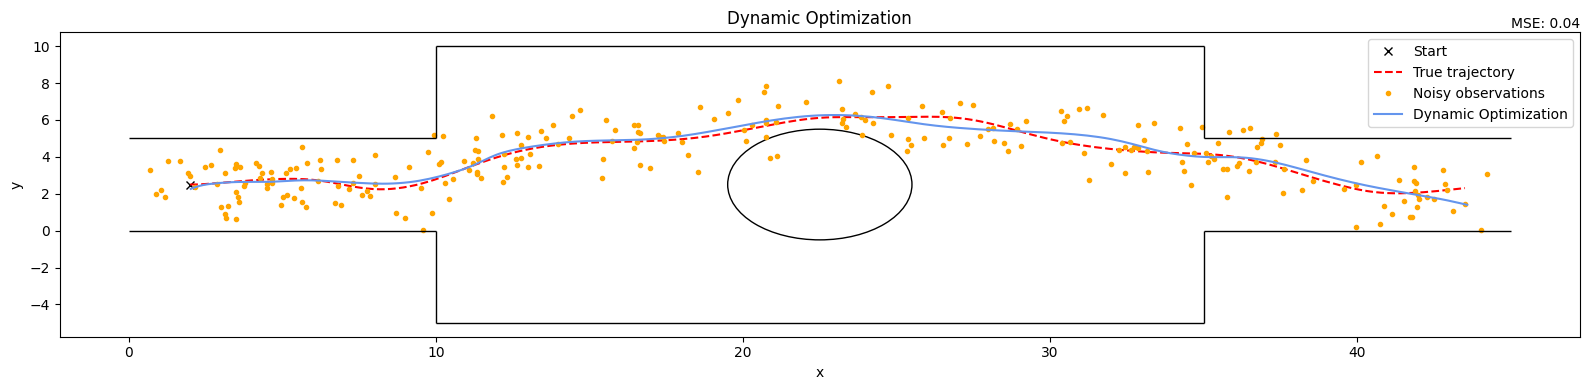

In [6]:
zero_cov = np.zeros((states.shape[0], states.shape[1], states.shape[1]))

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, extra=circle)
visualize_filter(states, measurements, casadi_states.T, zero_cov, extra=circle, title="Dynamic Optimization")

# Nonlinear

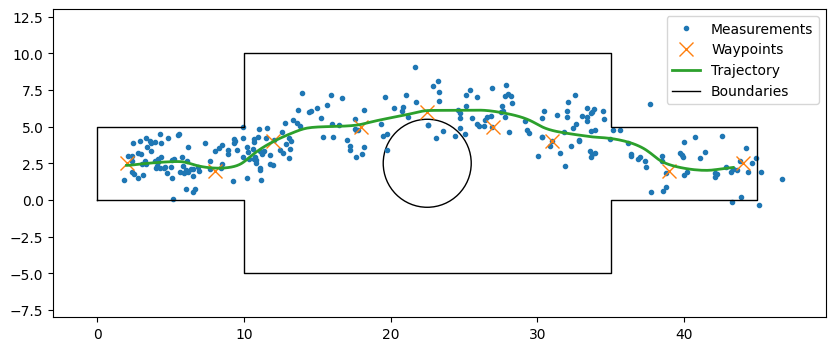

In [7]:
trajectory_linear = MPCTrajectory(x_points, y_points, line_segments, linearity='nonlinear', savepath="output/track_4_nonlinear.pkl")
states, measurements = trajectory_linear.get_data()

circle = plt.Circle((22.5, 2.5), 3, color='k', fill=False)
trajectory_linear.plot(extra=circle)

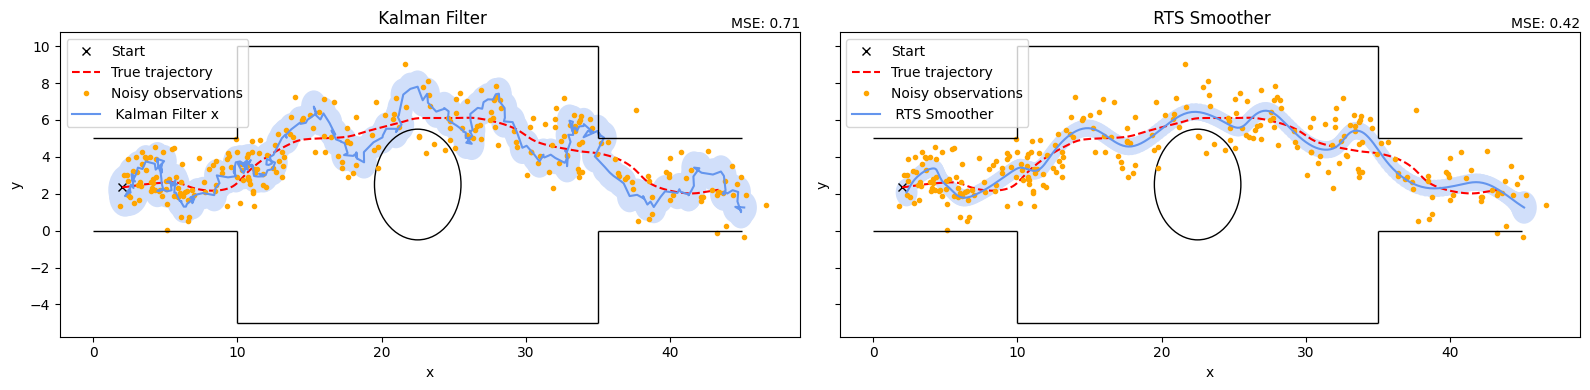

In [8]:
system = StateSpaceModel()

kalman_filter = KF(system.A, system.Q, system.H, system.R)
state_estimates, cov_estimates = kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, extra=circle)

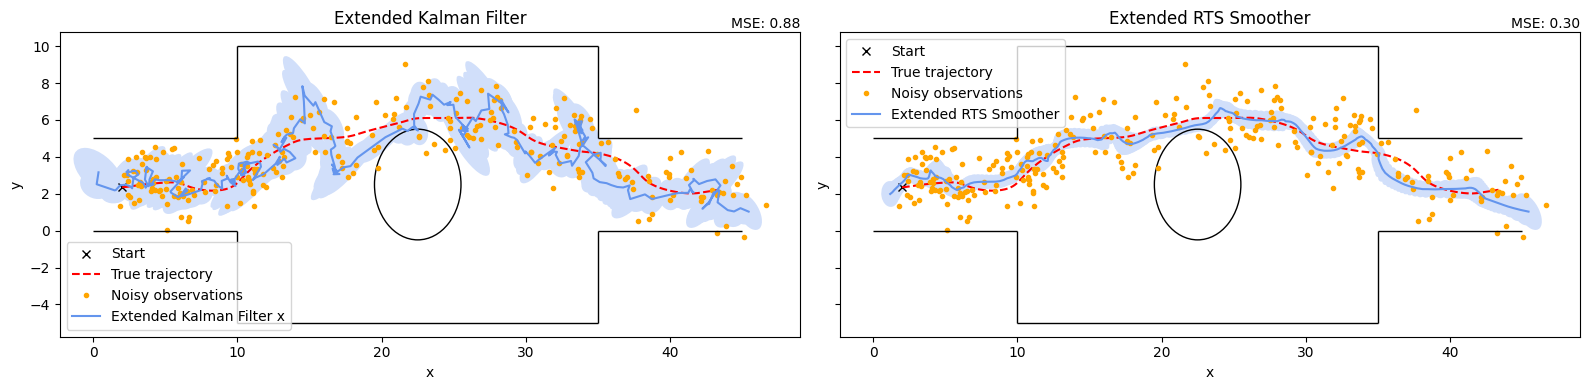

In [9]:
extendted_kalman_filter = EKF(system.f, system.F_jacobian, system.h, system.H_jacobian, system.Q, system.R)
state_estimates, cov_estimates = extendted_kalman_filter.filter(measurements)
state_estimates_smoothed, cov_estimates_smoothed = extendted_kalman_filter.smoother(state_estimates, cov_estimates)

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, variant="Extended", extra=circle)

In [10]:
def kalman_casadi_opt_nonlinear(states, y, f, h, Q, R):
    
        # x_{t+1} = f(x_t) + q_t
        # y_{t+1} = h(x_{t+1}) + r_{t+1}
    
        # J = sum(r^2) + sum(q^2)

        def diff(x, f):
            return x[:, 1:] - f(x[:, :-1], ca=True)
    
        opti = casadi.Opti()
    
        # Define the symbolic variables
        n_steps = states.shape[0] 
        n_states =  states.shape[1] # 4
        n_measurements = measurements.shape[1]
    
        # make casadi variables
        y = casadi.MX(y.T)
        Q = casadi.MX(Q)
        R = casadi.MX(R)
    
        # Define the decision variables
        x = opti.variable(n_states, n_steps)
        q = opti.variable(n_states, n_steps-1)
        r = opti.variable(n_measurements, n_steps)

        print(casadi.sin(x[0, :]).shape)
        print(casadi.vertcat(0.1 * casadi.sin(x[0, :]), 0.1 * casadi.sin(x[1, :]), casadi.MX.zeros(1, x.shape[1]), casadi.MX.zeros(1, x.shape[1])).shape)
    
        v1 = casadi.sumsqr(casadi.mtimes(casadi.inv(Q), q))
        v2 = casadi.sumsqr(casadi.mtimes(casadi.inv(R), r))

        V = v1 + v2

        opti.subject_to(diff(x, f) == q) # x_{t+1} = f(x_t) + q_t
        opti.subject_to(y - h(x, ca=True) == r) # y_{t+1} = h(x_{t+1}) + r_{t+1}

        opti.minimize(V)
    
        opti.solver('ipopt')
    
        sol = opti.solve()
    
        return sol.value(x), sol.value(q), sol.value(r)

casadi_states_linear, casadi_q_linear, casadi_r_linear = kalman_casadi_opt_linear(states, measurements, system.A, system.Q, system.H, system.R)
casadi_states_nonlinear, casadi_q_nonlinear, casadi_r_nonlinear = kalman_casadi_opt_nonlinear(states, measurements, system.f, system.h, system.Q, system.R)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     9088
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3474

Total number of variables............................:     2676
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1604
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.67e+01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

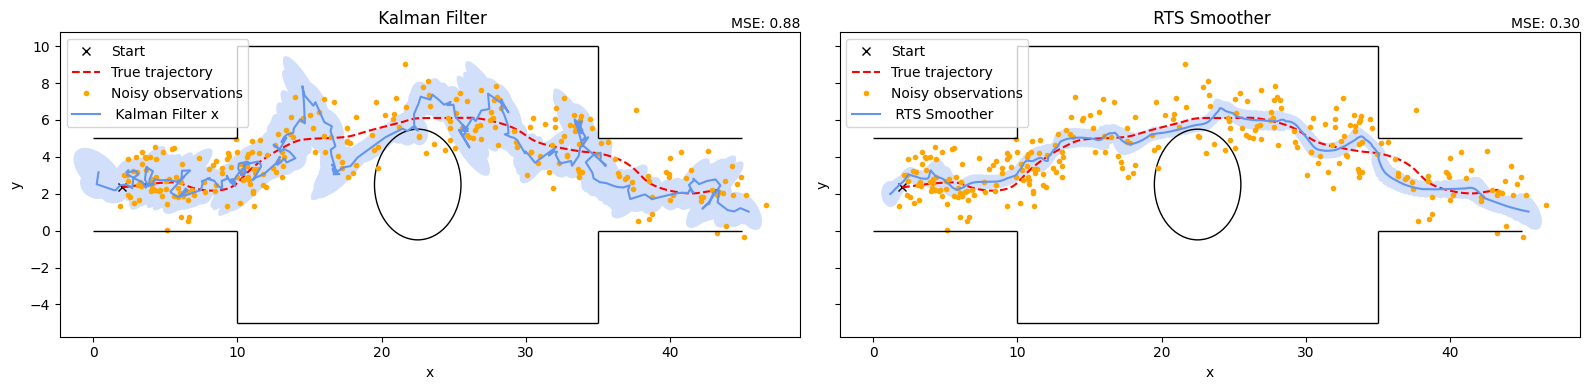

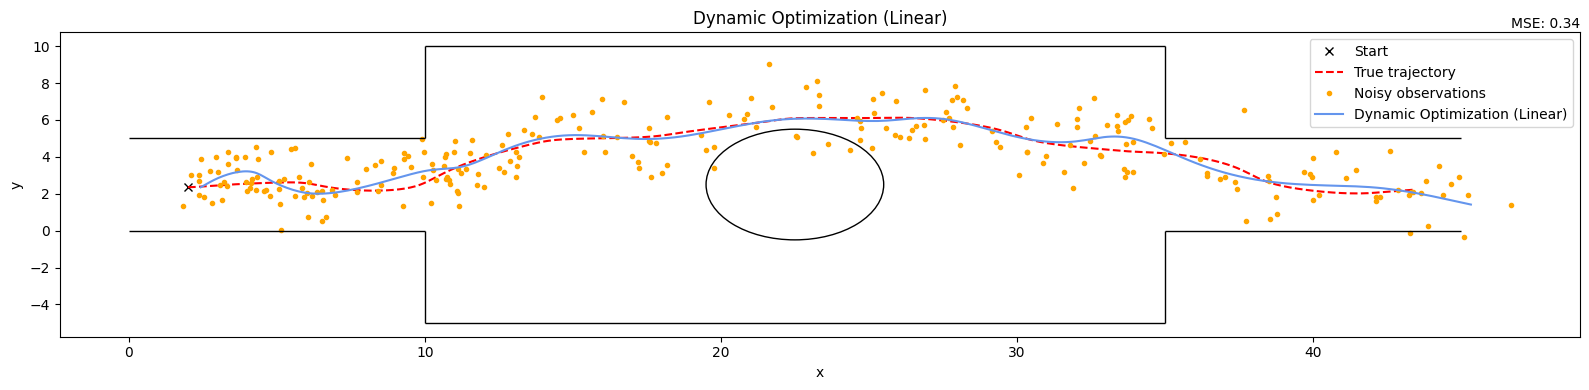

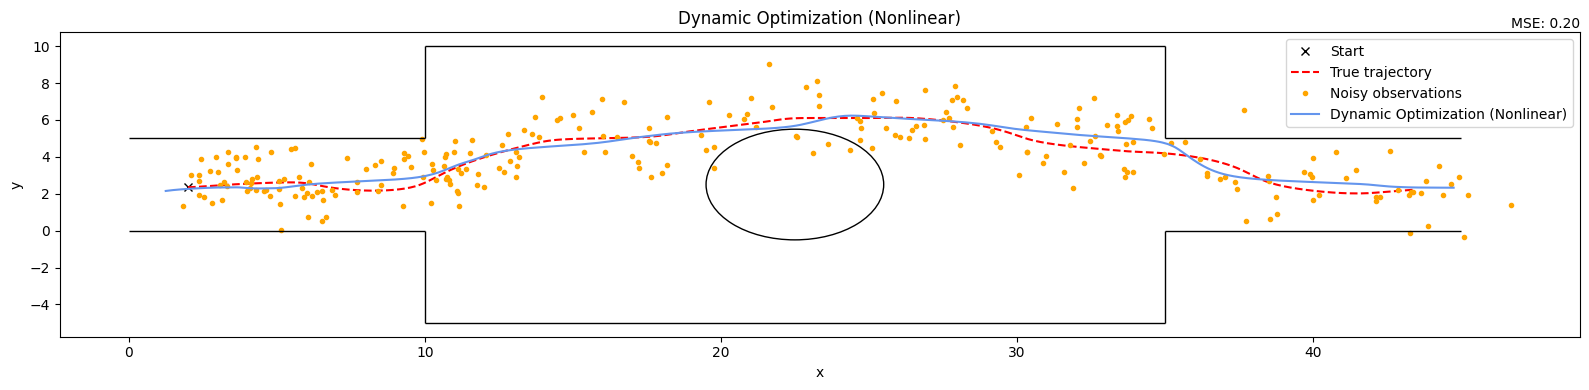

In [11]:
zero_cov = np.zeros((states.shape[0], states.shape[1], states.shape[1]))

visualize_filter_and_smoother(states, measurements, state_estimates, cov_estimates, state_estimates_smoothed, cov_estimates_smoothed, extra=circle)
visualize_filter(states, measurements, casadi_states_linear.T, zero_cov, extra=circle, title="Dynamic Optimization (Linear)")
visualize_filter(states, measurements, casadi_states_nonlinear.T, zero_cov, extra=circle, title="Dynamic Optimization (Nonlinear)")

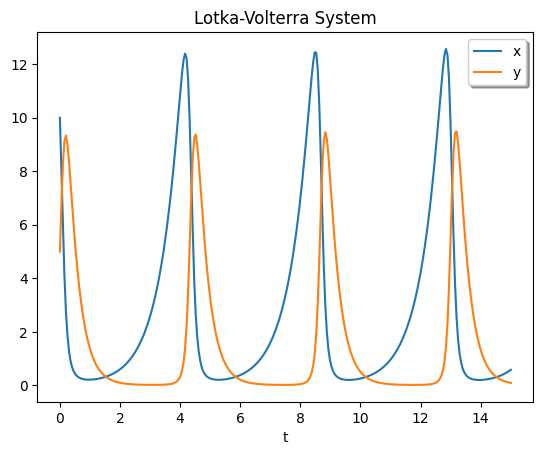

In [12]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def lotkavolterra(t, z, a, b, c, d):
    x, y = z
    return [a*x - b*x*y, -c*y + d*x*y]

sol = solve_ivp(lotkavolterra, [0, 15], [10, 5], args=(1.5, 1, 3, 1),
                dense_output=True)

t = np.linspace(0, 15, 300)
z = sol.sol(t)
import matplotlib.pyplot as plt
plt.plot(t, z.T)
plt.xlabel('t')
plt.legend(['x', 'y'], shadow=True)
plt.title('Lotka-Volterra System')
plt.show()

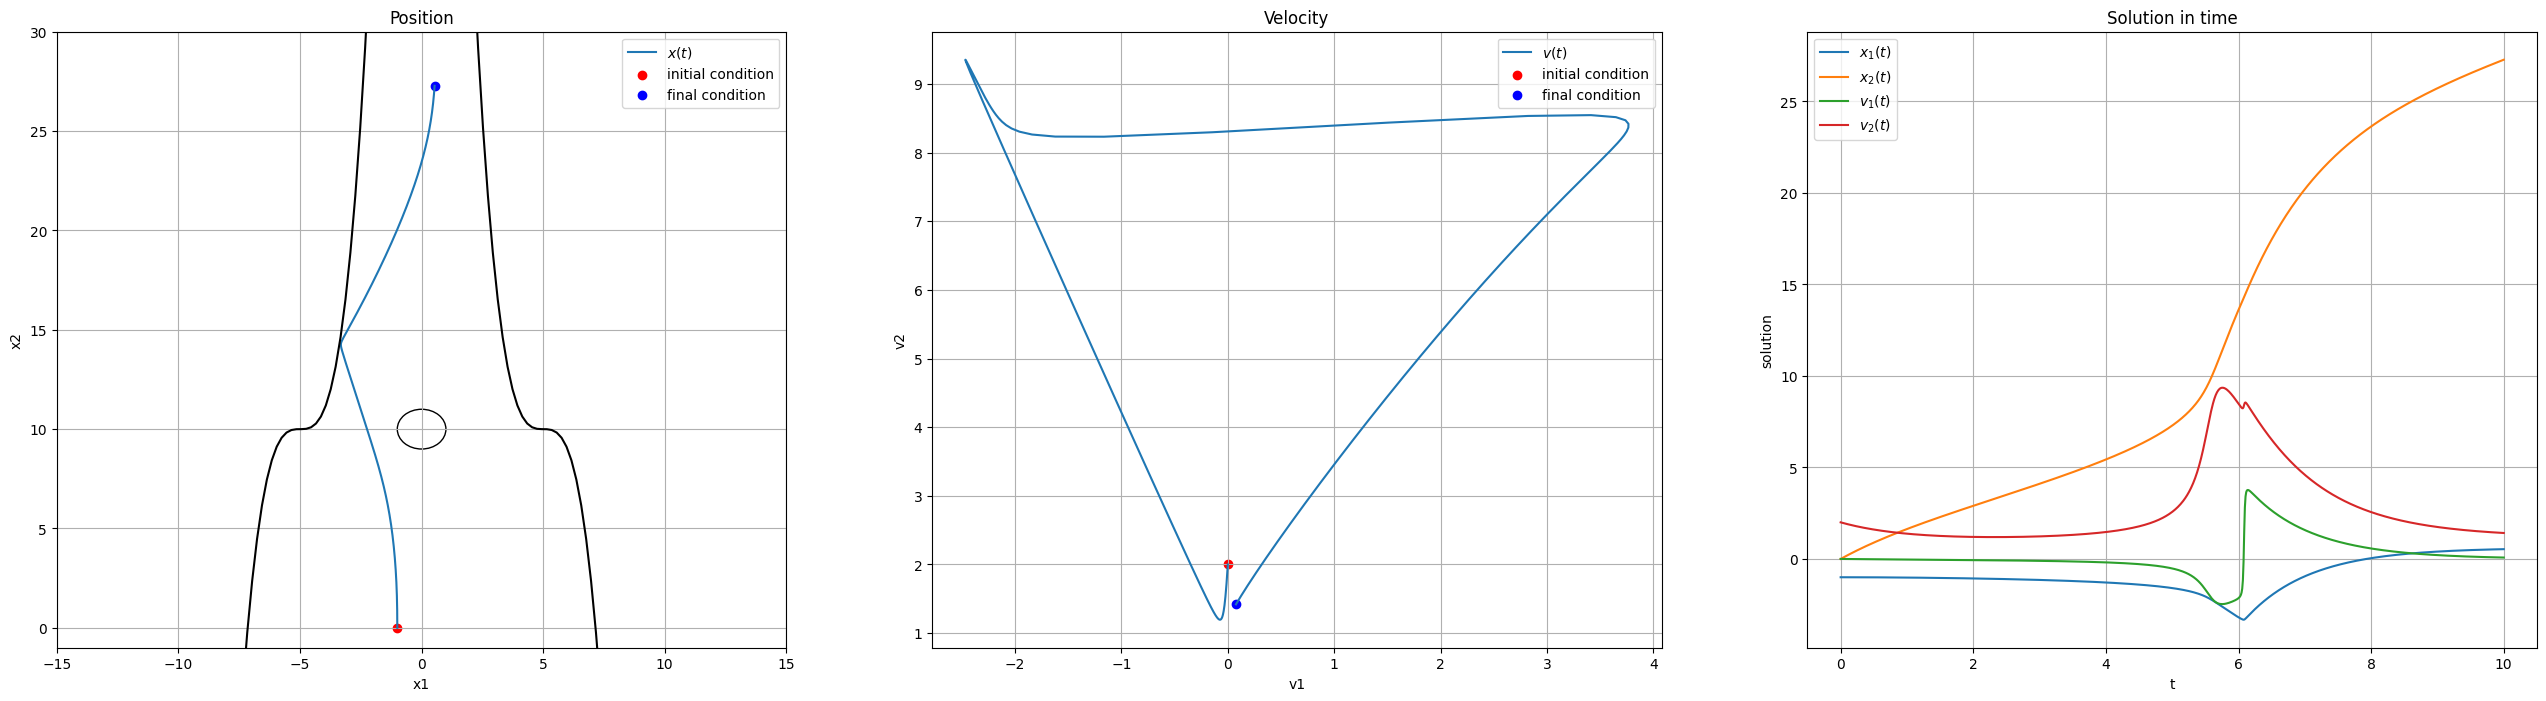

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def plot_solution(solution, center, radius):
    # Plot the results
    fig, ax = plt.subplots(1, 3, figsize=(32, 8))


    ax[0].plot(solution.y[0], solution.y[1], label='$x(t)$')
    ax[0].scatter(solution.y[0][0], solution.y[1][0], label='initial condition', color='red') # plot initial condition
    ax[0].scatter(solution.y[0][-1], solution.y[1][-1], label='final condition', color='blue') # plot final condition

    circle = plt.Circle((center[0], center[1]), radius, color='k', fill=False)
    ax[0].add_artist(circle)

    def g(x, w1=w1, w2=w2):
        return w1+(x+w2)**3
    
    def g2(x, w1=w1, w2=w2):
        return w1+(-x+w2)**3

    ax[0].plot(np.linspace(-10, 10, 100), [g(x) for x in np.linspace(-10, 10, 100)], color='k')
    ax[0].plot(np.linspace(-10, 10, 100), [g2(x) for x in np.linspace(-10, 10, 100)], color='k')

    ax[0].set_xlabel('x1')
    ax[0].set_ylabel('x2')
    ax[0].set_title('Position')

    ax[0].set_xlim([-15, 15])
    ax[0].set_ylim([-1, 30])

    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(solution.y[2], solution.y[3], label='$v(t)$')
    ax[1].scatter(solution.y[2][0], solution.y[3][0], label='initial condition', color='red') # plot initial condition
    ax[1].scatter(solution.y[2][-1], solution.y[3][-1], label='final condition', color='blue') # plot final condition

    ax[1].set_xlabel('v1')
    ax[1].set_ylabel('v2')
    ax[1].set_title('Velocity')

    ax[1].grid(True)
    ax[1].legend()

    ax[2].plot(solution.t, solution.y[0], label='$x_1(t)$')
    ax[2].plot(solution.t, solution.y[1], label='$x_2(t)$')
    ax[2].plot(solution.t, solution.y[2], label='$v_1(t)$')
    ax[2].plot(solution.t, solution.y[3], label='$v_2(t)$')

    ax[2].set_xlabel('t')
    ax[2].set_ylabel('solution')
    ax[2].set_title('Solution in time')

    ax[2].grid(True)
    ax[2].legend()

    plt.show()

# Define the system of coupled ODEs for 4 dimensions
def system(t, y):
    x1, x2, v1, v2 = y

    #u = -x2
    #du_dx1 = 0
    #du_dx2 = -1

    #u = (np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2) - radius)**-1 - x2
    #du_dx1 = -((2*x1 - radius) / ((np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2) - radius)**3)*np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2)) 
    #du_dx2 = -((2*x2 - radius) / ((np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2) - radius)**3)*np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2)) - 1

    
    u = (np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2) - radius)**-1 - s*x2 + (-w1 + x2 - (x1+w2)**3)**-2

    du_dx1 = -((2*x1 - radius) / ((np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2) - radius)**3)*np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2)) + 6 * (x1+w2)**2 / (-w1 + x2 - (x1+w2)**3)**3 + 6 * (x1-w2)**2 / (w1 + x2 - (x1-w2)**3)**3
    du_dx2 = -((2*x2 - radius) / ((np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2) - radius)**3)*np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2)) - s + 2 / (-w1 + x2 - (x1+w2)**3)**3 + 2 / (w1 + x2 - (x1-w2)**3)**3

    #u = (np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2) - radius)**-2 + np.abs(5 - x1)**-2 + np.abs(-5 - x1)**-2 - x2
    #du_dx1 = -((2*x1 - radius) / ((np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2) - radius)**3)*np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2)) - 2 * np.abs(5 + x1)**-3 - 2 * np.abs(-5 + x1)**-3
    #du_dx2 = -((2*x2 - radius) / ((np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2) - radius)**3)*np.sqrt((x1 - center[0])**2 + (x2 - center[1])**2)) - 1

    dx1_dt = v1
    dx2_dt = v2
    dv1_dt = -du_dx1 - l * v1
    dv2_dt = -du_dx2 - l * v2

    return [dx1_dt, dx2_dt, dv1_dt, dv2_dt]

# Set the initial conditions
#initial_conditions = [0, 0, 0, 16]
initial_conditions = [-1, 0, 0, 2]

# Set the time span
t_max = 10
t_span = (0, t_max)

center = np.array([0, 10])
radius = 1

w1, w2 = 10, 5

l = 1 # friction
s = 1 # slope


# r = 1, l = 1, s = 1, w1 = 10, w2 = 5, x1=-1, v2=2, t_max=10 -> pretty cool solution
# Solve the ODEs
solution = solve_ivp(system, t_span, initial_conditions, t_eval=np.linspace(t_span[0], t_span[1], 1000), atol=1e-8, rtol=1e-8)

plot_solution(solution, center, radius)

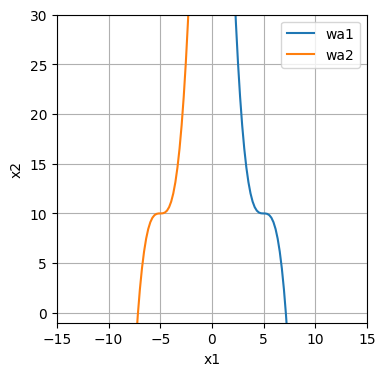

In [42]:
def wa1(x, p1, p2):
    return p1 + (-x + p2)**3


def wa2(x, p1, p2):
    return p1 + (x + p2)**3


fig, ax = plt.subplots(1, 1, figsize=(4, 4))

x = np.linspace(-10, 10, 100)

p1, p2 = 10, 5

ax.plot(x, wa1(x, p1, p2), label='wa1')
ax.plot(x, wa2(x, p1, p2), label='wa2')

ax.set_xlabel('x1')
ax.set_ylabel('x2')

ax.set_xlim([-15, 15])
ax.set_ylim([-1, 30])

ax.grid(True)
ax.legend()

plt.show()